# ImageNet Example All Explainers

In this notebook, we will demonstrate the functionality of the various explainers included in the library.

For this purpose, we use a pre-trained ResNet18 from `torchvision` and ImageNet dataset.


**Contents**
1. [Preliminaries](#preliminaries)
    - [Load a pre-trained model](#model)
    - [Load data](#data)
2. [Explanation using `pnpxai`](#expl)
    - [LRP: Uniform-epsilon](#lrp)
    - [IntegratedGradients](#ig)
    - [Lime](#lime)
    - [KernelShap](#ks)
    - [GradCam](#gcam)
    - [GuidedGradCam](#ggcam)
    - [Visualize all](#vis)
3. [What's next?](#next)

## 1. Preliminaries<a name="preliminaries"></a>

### 1.1 Load a pre-trained model<a name="model"></a>

In this example, we load a pre-trained ResNet18 from `torchvison`. We have prepared `get_torchvision_model(model_name: str)` for tutorials, which returns a pre-trained model and its default data transformation from the model name. Loads the model and gets the transform.

In [1]:
from helpers import get_torchvision_model

model, transform = get_torchvision_model("resnet18")

### 1.2 Load data<a name="data"></a>

We have prepared a subset of ImageNet dataset and `get_imagenet_dataset(transform)` for tutorials, which loads the dataset. Loads the data.

In [2]:
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt

from helpers import get_imagenet_dataset

# load data
indices = [0, 7, 14, 403]
dataset = get_imagenet_dataset(
    transform=transform,
    indices=indices,
    root_dir="./data/ImageNet"
)
dataloader = DataLoader(dataset=dataset, batch_size=len(indices))
inputs, labels = next(iter(dataloader))

Visualizes the data loaded.

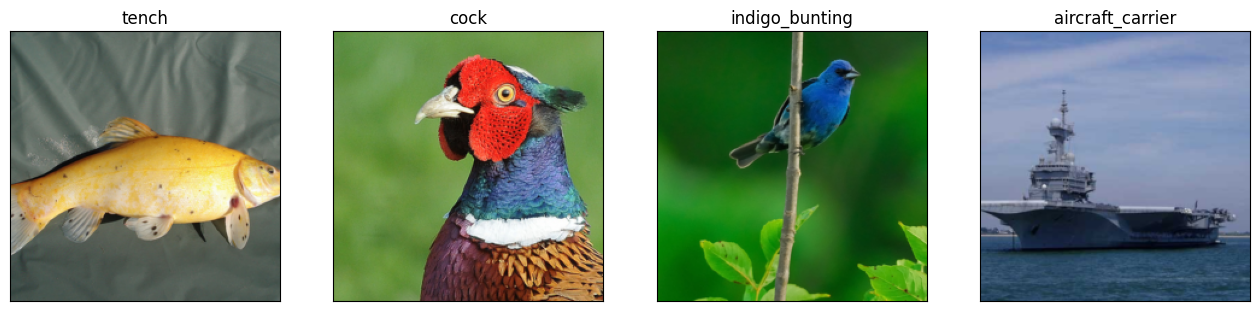

In [3]:
# denormalize input data
def denormalize_image(inputs, mean, std):
    return (
        inputs
        * torch.Tensor(std)[:, None, None]
        + torch.Tensor(mean)[:, None, None]
    ).permute(1, 2, 0).detach().numpy()

# show images
nrows, ncols = 1, 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

for c, (input, label) in enumerate(zip(inputs, labels)):
    axes[c].imshow(denormalize_image(input, mean=transform.mean, std=transform.std))
    axes[c].set_title(dataset.dataset.idx_to_label(label.item()))
    axes[c].set_xticks([])
    axes[c].set_yticks([])

## 2. Explanation using `pnpxai`

`pnpxai.explainers` contains a collection of state-of-the-art XAI methods that can generate attribution-based explanations for any AI model, such as SHAP, LIME, IG, and LRP. All the explainers computes attributions based on the certificated or promising open sources such as `captum` or `zennit` while the interfaces are unified to `captum`-styled one.

**Available explainers**

<table>
  <tr>
    <th colspan="2">PnP XAI Explainer</th>
    <th>Core 3rd party</th>
    <th>Style</th>
  </tr>
  <tr>
    <td>LRP-based</td>
    <td>LRP</td>
    <td>zennit</td>
    <td rowspan="7">captum</td>
  </tr>
  <tr>
    <td>Gradient-based</td>
    <td>IntegratedGradients</td>
    <td>zennit</td>
  </tr>
  <tr>
    <td rowspan="2">Perturbation-based</td>
    <td>Lime</td>
    <td>captum</td>
  </tr>
  <tr>
    <td>KernelShap</td>
    <td>captum</td>
  </tr>
  <tr>
    <td rowspan="2">CAM-based</td>
    <td>GradCam</td>
    <td>captum</td>
  </tr>
  <tr>
    <td>GuidedGradCam</td>
    <td>captum</td>
  </tr>
</table>

In [4]:
from pnpxai.explainers import AVAILABLE_EXPLAINERS

print([explainer.__name__ for explainer in AVAILABLE_EXPLAINERS])

['Lime', 'KernelShap', 'GuidedGradCam', 'GradCam', 'IntegratedGradients', 'LRP']


You can create any explainer following the `captum`-styled interface: (1) creating an explainer's instance by model and then (2) computing attributions by input data: 

```python
from pnpxai.explainers import Explainer

explainer = Explainer(model)
attributions = explainer.attribute(inputs, targets, **kwargs)
```

### 2.1 LRP

`LRP` computes LRP attributions with uniform composite of epsilon rules. By default, `epsilon=0.25`.

Computes LRP attributions.

In [5]:
from pnpxai.explainers import LRP

explainer = LRP(model)
attrs_lrp = explainer.attribute(inputs=inputs, targets=labels)

Computes LRP attributions with a custom epsilon value: `epsilon=0.7`.

In [6]:
attrs_lrp_custom = explainer.attribute(inputs=inputs, targets=labels, epsilon=.7)

Visualizes LRP attributions.

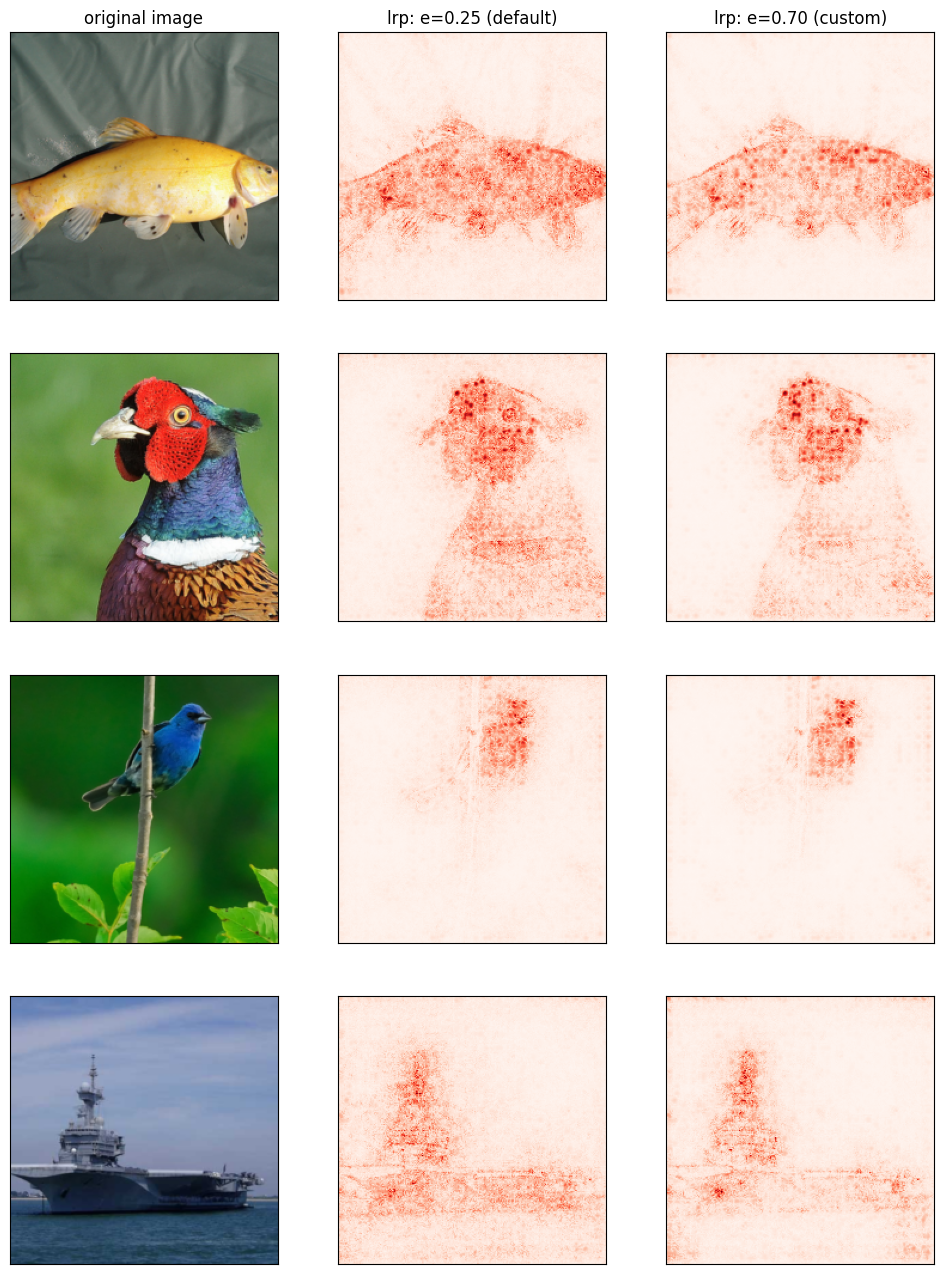

In [7]:
# postprocess for attributions
def postprocess_attr(attr, sign=None, scale=None):
    if sign == 'absolute':
        attr = torch.abs(attr)
    elif sign == 'positive':
        attr = torch.nn.functional.relu(attr)
    elif sign == 'negative':
        attr = -torch.nn.functional.relu(-attr)

    postprocessed = attr.permute((1, 2, 0)).sum(dim=-1)
    attr_max = torch.max(postprocessed)
    attr_min = torch.min(postprocessed)
    postprocessed = (postprocessed - attr_min) / (attr_max - attr_min)
    if scale == "sqrt":
        postprocessed = postprocessed.sqrt()
    return postprocessed.cpu().detach().numpy()

# visualize attributions
nrows, ncols = 4, 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
for r, (input, attr_default, attr_custom) in enumerate(zip(inputs, attrs_lrp, attrs_lrp_custom)):
    axes[r, 0].imshow(denormalize_image(input, mean=transform.mean, std=transform.std))
    axes[r, 1].imshow(postprocess_attr(attr_default, sign="absolute", scale="sqrt"), cmap="Reds")
    axes[r, 2].imshow(postprocess_attr(attr_custom, sign="absolute", scale="sqrt"), cmap="Reds")
    if r == 0:
        axes[r, 0].set_title("original image")
        axes[r, 1].set_title("lrp: e=0.25 (default)")
        axes[r, 2].set_title("lrp: e=0.70 (custom)")

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

### 2.2 IntegratedGradients<a name="ig"></a>

Computes integrated gradients.

In [8]:
from pnpxai.explainers import IntegratedGradients

ig = IntegratedGradients(model)
attrs_ig = ig.attribute(inputs=inputs, targets=labels)

### 2.3 Lime<a name="lime"></a>

Computes LIME attributions.

In [9]:
from pnpxai.explainers import Lime

lime = Lime(model)
attrs_lime = lime.attribute(inputs=inputs, targets=labels)

/home/gkim/Projects/pnpxai/.venv/lib/python3.10/site-packages/captum/attr/_core/lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(


### 2.4 KernelShap<a name="ks"></a>

Computes Kernel SHAP attributions.

In [10]:
from pnpxai.explainers import KernelShap

ks = KernelShap(model)
attrs_ks = ks.attribute(inputs=inputs, targets=labels)

/home/gkim/Projects/pnpxai/.venv/lib/python3.10/site-packages/captum/attr/_core/lime.py:1109: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(


### 2.5 GradCam<a name="gcam"></a>

Computes Grad CAM attributions.

In [11]:
from pnpxai.explainers import GradCam

gcam = GradCam(model)
attrs_gcam = gcam.attribute(inputs=inputs, targets=labels)

### 2.6 GuidedGradCam<a name="ggcam"></a>

Compute Guided Grad CAM attributions.

In [12]:
from pnpxai.explainers import GuidedGradCam

ggcam = GuidedGradCam(model)
attrs_ggcam = ggcam.attribute(inputs=inputs, targets=labels)

/home/gkim/Projects/pnpxai/.venv/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/home/gkim/Projects/pnpxai/.venv/lib/python3.10/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


### Visualize all<a name="vis"></a>

Visualizes all attributions.

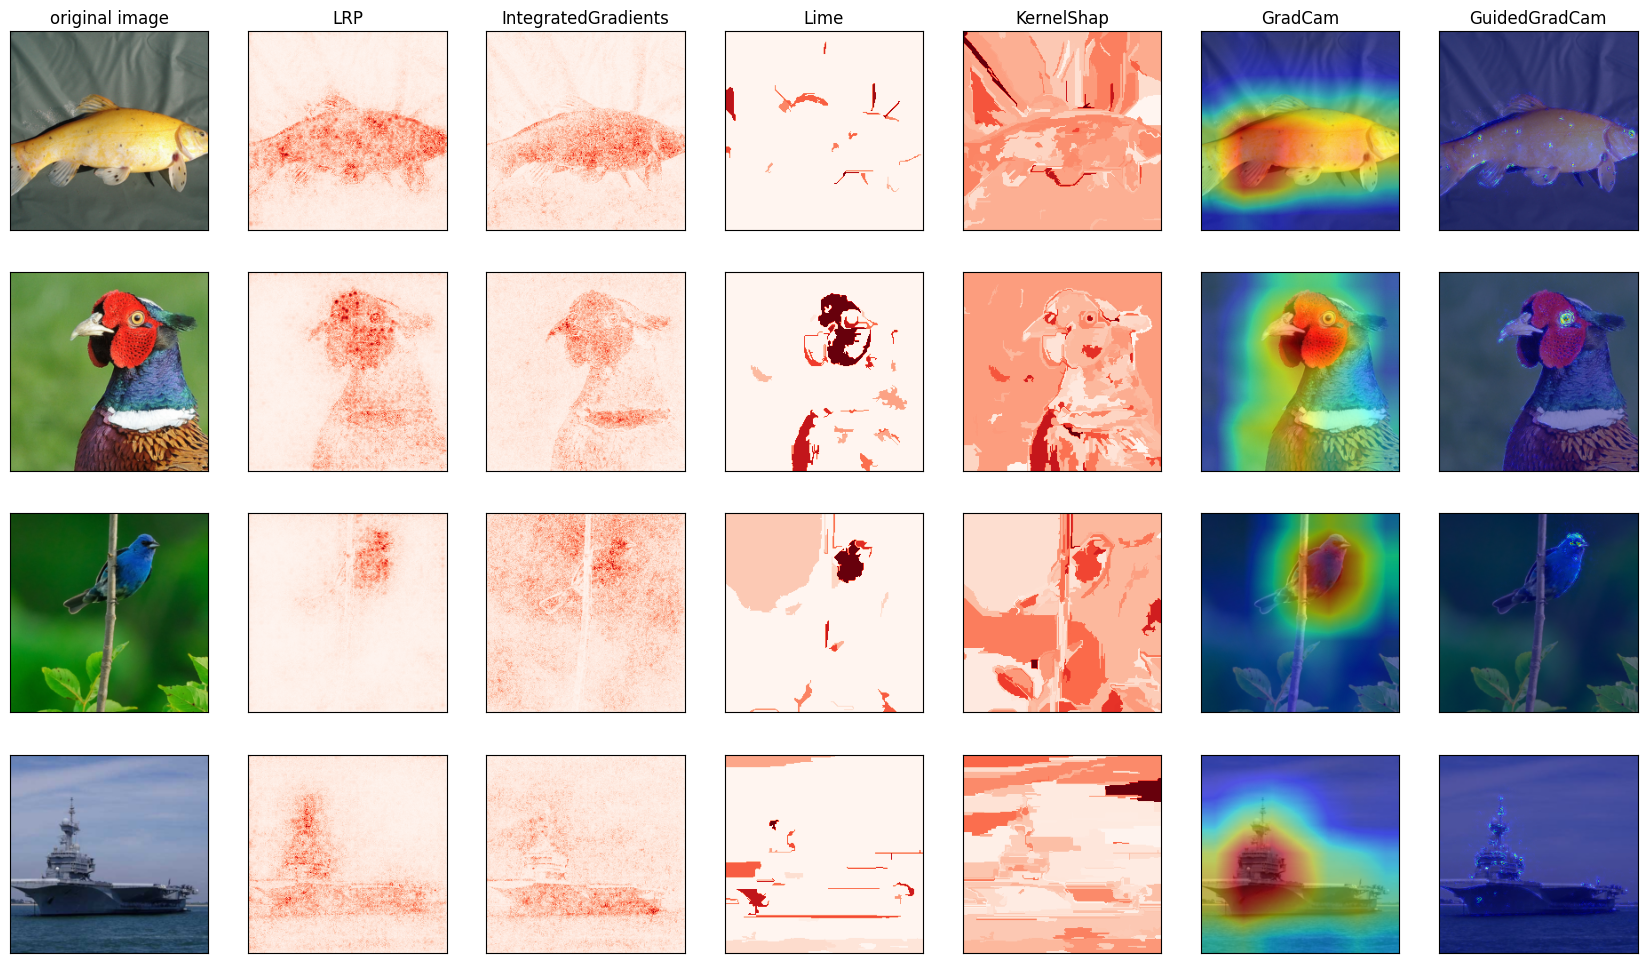

In [13]:
visdata_all = [
    inputs,
    attrs_lrp,
    attrs_ig,
    attrs_lime,
    attrs_ks,
    attrs_gcam,
    attrs_ggcam,
]

nrows, ncols = len(inputs), len(visdata_all)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3*ncols, 3*nrows))
for r, visdata in enumerate(zip(*visdata_all)):
    axes[r, 0].imshow(denormalize_image(visdata[0], mean=transform.mean, std=transform.std))
    axes[r, 1].imshow(postprocess_attr(visdata[1], sign="absolute", scale="sqrt"), cmap="Reds")
    axes[r, 2].imshow(postprocess_attr(visdata[2], sign="absolute", scale="sqrt"), cmap="Reds")
    axes[r, 3].imshow(postprocess_attr(visdata[3], sign="absolute", scale="sqrt"), cmap="Reds")
    axes[r, 4].imshow(postprocess_attr(visdata[4], sign="absolute", scale="sqrt"), cmap="Reds")
    axes[r, 5].imshow(denormalize_image(visdata[0], mean=transform.mean, std=transform.std))
    axes[r, 5].imshow(postprocess_attr(visdata[5], sign="absolute"), cmap="jet", alpha=.5)
    axes[r, 6].imshow(denormalize_image(visdata[0], mean=transform.mean, std=transform.std))
    axes[r, 6].imshow(postprocess_attr(visdata[6], sign="absolute"), cmap="jet", alpha=.5)

for r, (input, attr_default, attr_custom) in enumerate(zip(inputs, attrs_lrp, attrs_lrp_custom)):
    if r == 0:
        axes[r, 0].set_title("original image")
        axes[r, 1].set_title("LRP")
        axes[r, 2].set_title("IntegratedGradients")
        axes[r, 3].set_title("Lime")
        axes[r, 4].set_title("KernelShap")
        axes[r, 5].set_title("GradCam")
        axes[r, 6].set_title("GuidedGradCam")

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

## 3. What's next?<a name="next"></a>

In this tutorial, we've briefly learned about how to use the explainers and, by comparing the visualization results, found that some explanations are aligned to human intelligence while the others are not. However, the explanation itself tells little about which explanation is good or better than the others. We provides various ways, or evaluation metrics, to evaluate and compare the performance and explainability of AI models, such as correctness, and continuity. Let's check how to use the metrics for the next step.

- [Tutorial: ImageNet Example All Metrics](#./imagenet_example_all_metrics.ipynb)